In [1]:
#learndataa learndataa learndataa learndataa learndataa learndataa learndataa learndataa learndataa

# Chemometrics - Amylose content in rice

### Data Source

Dataset of Near-infrared spectroscopy measurement for amylose determination using PLS algorithms

    - License: ---
    - Authors:  P. Sampaio, A. Soares, A. Castanho, A.S. Almeida, J. Oliveira, C. Brites [Instituto Nacional de Investigação Agrária e Veterinária (INIAV); Faculty of Engineering, Lusophone University of Humanities and Technology, Portugal]
    - Source Link: https://www.sciencedirect.com/science/article/pii/S2352340917305176
    - Download: https://ars.els-cdn.com/content/image/1-s2.0-S2352340917305176-mmc3.zip
    - Data last updated: 2017
    - Origin: Data in Brief, Elsevier, Science Direct
    - Citation: P. Sampaio, A. Soares, A. Castanho, A.S. Almeida, J. Oliveira, C. Brites, Dataset of Near-infrared spectroscopy measurement for amylose determination using PLS algorithms, Volume 15, 2017, Pages 389-396, ISSN 2352-3409, https://doi.org/10.1016/j.dib.2017.09.077.


### Import libraries

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io

from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.cross_decomposition import PLSRegression

In [3]:
### Check version
import sys
import sklearn
print(sys.version)
!python --version
print("numpy: ", np.__version__)
print("sklearn: ", sklearn.__version__)

3.8.3 (default, Jul  2 2020, 11:26:31) 
[Clang 10.0.0 ]
Python 3.8.3
numpy:  1.19.5
sklearn:  0.24.0


# Part - I

### Data

#### Read file

In [4]:
path = '/Users/erv/Desktop/amylose/'

In [5]:
mmc3 = scipy.io.loadmat(path +'mmc3.mat')
print(type(mmc3))

<class 'dict'>


In [68]:
iodine = pd.read_excel(path + 'mmc2.xlsx')
print(iodine.shape)
iodine.head(2)

(313, 2)


,Iodine,NIR-model
0,0.0,1.5540
1,2.0,3.3954


### Check

In [7]:
mmc3.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Xcal', 'Xtest', 'ycal', 'ytest', 'xaxis', 'SpectraTotal'])

In [30]:
Xcal = mmc3['Xcal']
Xtest = mmc3['Xtest']

ycal =mmc3['ycal']
ytest=mmc3['ytest']

xaxis=mmc3['xaxis']
xaxis = np.flip(xaxis) #<--- * * *

SpectraTotal=mmc3['SpectraTotal']

print('Xcal.shape:', Xcal.shape)
print('ycal.shape:', ycal.shape)
print('Xtest.shape:', Xtest.shape)
print('ytest.shape:', ytest.shape)
print('xaxis.shape:', xaxis.shape)
print('SpectraTotal.shape:', SpectraTotal.shape)

Xcal.shape: (203, 1154)
ycal.shape: (203, 1)
Xtest.shape: (110, 1154)
ytest.shape: (110, 1)
xaxis.shape: (1154, 1)
SpectraTotal.shape: (372, 1154)


### Visualize





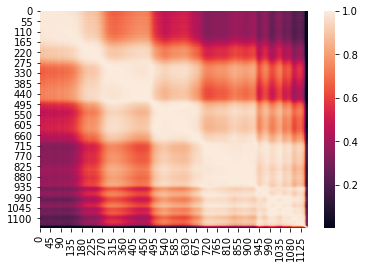

In [23]:
# Correlation
sns.heatmap(np.corrcoef(Xcal, rowvar=False)**2)

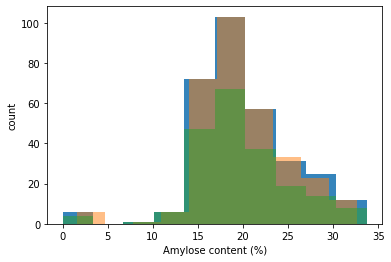

In [28]:
# Amylose content
plt.hist(iodine['Iodine'], alpha=0.9)
plt.hist(iodine['NIR-model'], alpha=0.5)
plt.hist(ycal, alpha=0.5)

plt.xlabel('Amylose content (%)')
plt.ylabel('count')
plt.show()

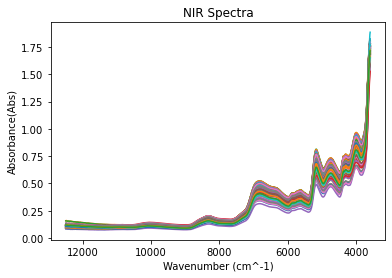

In [34]:
# Spectra: Train

for i in range(len(Xcal)):
    plt.plot(xaxis, Xcal[i,:])

plt.xlabel('Wavenumber (cm^-1)')
plt.ylabel('Absorbance(Abs)')
plt.title('NIR Spectra')
plt.gca().invert_xaxis()
plt.show()
 


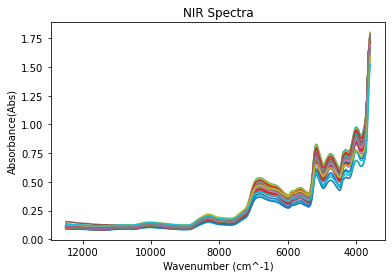

In [35]:
# Spectra: Test

for i in range(len(Xtest)):
    plt.plot(xaxis, Xtest[i,:])

plt.xlabel('Wavenumber (cm^-1)')
plt.ylabel('Absorbance(Abs)')
plt.title('NIR Spectra')
plt.gca().invert_xaxis()
plt.show()



# Part - II

In [40]:
# MSC : Multiplicative Scatter Correction
def preprocess_msc(x):
    # zero mean each spectra from each row
    x = (x.T - np.mean(x.T, axis=0)).T
    
    # initialize
    temp = []
    c = int(len(x))
    x_msc = np.zeros(x.shape)
    
    # process
    for i in range (x.shape[0]):
        for j in range (0, c, 10):
            temp.append(np.mean(x[j:j+10], axis=0))
            # polyfit
            fit = np.polyfit(temp[i], x[i,:], 1, full=True)
            # update
            x_msc[i,:] = (x[i,:] - fit[0][1])/ fit[0][0]
     
    print('-'*50, 'msc done !')
    return (x_msc)
            

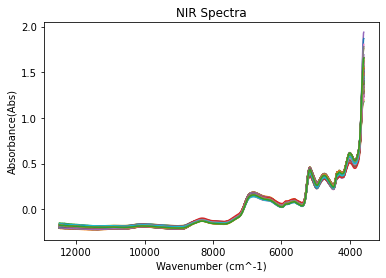

In [39]:
x = Xcal.copy()
x_msc = preprocess_msc(x)

n = len(x_msc)

for i in range(n):
    plt.plot(xaxis, x_msc[i,:])

plt.xlabel('Wavenumber (cm^-1)')
plt.ylabel('Absorbance(Abs)')
plt.title('NIR Spectra')
plt.gca().invert_xaxis()
plt.show()


In [41]:
# Scaling

def scalethis(x_train, x_test, y_train, y_test):
    # Scale x:
    scl = preprocessing.StandardScaler()
    scl.fit(x_train)
    x_train = scl.transform(x_train)
    x_test = scl.transform(x_test)
    
    # Scale y:
    scl = preprocessing.StandardScaler()
    scl.fit(y_train)
    y_train = scl.transform(y_train)
    y_test = scl.transform(y_test)   
    
    print('-'*50, 'scaling done !')
    return (x_train, x_test, y_train, y_test)

In [42]:
# Derivative
def der(x_train, x_test, dv=1):
    # initialize a dictionary
    out={}
    # initialize names
    n, names = 0, ['x_train', 'x_test']
    
    for x in [x_train, x_test]:
        c=0
        for i in range(len(x)):
            d = np.gradient(x[i,:])
            if(dv==2):
                d = np.gradient(d)
            if c==0:
                c+=1
                x_d=d
            else:
                x_d = np.vstack([x_d,d])
                
        out[names[n]] = x_d
        n +=1
        
    x_train = out['x_train']
    x_test = out['x_test']
    
    print('-'*50, 'derivative done !')
    return x_train, x_test
    
    

In [43]:
# Fit and predict
def fitthis(x_train, x_test, y_train, y_test, nc=2):  
    try:
    
        plscr = PLSRegression(n_components=nc)
        plscr.fit(x_train, y_train)

        y_pred = plscr.predict(x_test)
        mse = metrics.mean_squared_error(y_test, y_pred)
        r2 = metrics.r2_score(y_test, y_pred)

        return mse, r2
    
    except:
        pass

# Part - III

In [67]:
x_train = Xcal.copy()
y_train = ycal.copy()
x_test = Xtest.copy()
y_test = ytest.copy()




# Zero out low values
cut = .22
x_train[x_train <= cut] = 0
x_test[x_test <= cut] = 0


# MSC
x_train = preprocess_msc(x_train)
x_test = preprocess_msc(x_test)




# Get deriative
#x_train, x_test = der(x_train, x_test, dv=2)


# Scale
x_train, x_test, y_train, y_test = scalethis(x_train, x_test, y_train, y_test)


# Fit
maxr2 = 0
bestnc = 0
the_mse = 0

for nc in range(2, 100):
    
    try:
        mse, r2 = fitthis(x_train, x_test, y_train, y_test, nc=nc)
        if(r2 > maxr2):
            maxr2 = r2
            bestnc = nc
            the_mse = mse
    
    except:
        pass
    
print('n_components:', bestnc)
print("mse:", mse)
print("r2:", maxr2)

-------------------------------------------------- msc done !
-------------------------------------------------- msc done !
-------------------------------------------------- scaling done !
n_components: 46
mse: 0.39123265442226596
r2: 0.8588217113389571


In [ ]:
# no der
n_components: 46
mse: 0.39123265442226596
r2: 0.8588217113389571

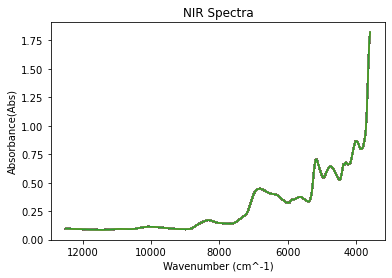

In [56]:
# Spectra: Train

for i in range(len(Xcal)):
    plt.plot(xaxis, Xcal[0,:])

plt.xlabel('Wavenumber (cm^-1)')
plt.ylabel('Absorbance(Abs)')
plt.title('NIR Spectra')
plt.gca().invert_xaxis()
plt.show()
 


0.2564816024528742


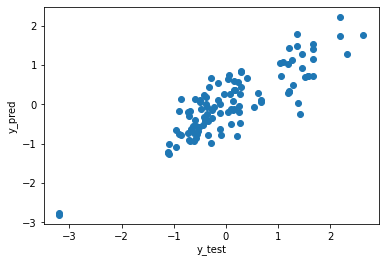

In [64]:
plscr = PLSRegression(n_components=bestnc)
plscr.fit(x_train, y_train)

y_pred = plscr.predict(x_test)
mse = metrics.mean_squared_error(y_test, y_pred)
print(mse)

plt.scatter(y_test, y_pred)
plt.xlabel('y_test')
plt.ylabel('y_pred')
plt.show()

In [70]:
from sklearn import linear_model

mse: 0.4068549489223031
r2: 0.5819957205743054


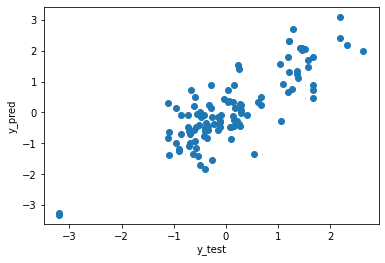

In [71]:
# Linear Regression
reg = linear_model.LinearRegression()
reg.fit(x_train, y_train)
y_pred = reg.predict(x_test)

mse = metrics.mean_squared_error(y_test,y_pred)
r2 = metrics.r2_score(y_test, y_pred)

print('mse:', mse)
print('r2:', r2)

plt.scatter(y_test, y_pred)
plt.xlabel('y_test')
plt.ylabel('y_pred')
plt.show()

# Congratulations on completing the machine learning project!
## Hope you enjoyed the data analysis. Thank you !!!
### Please like, share and subscribe to learndataa

https://www.youtube.com/c/learndataa

In [2]:
#learndataa learndataa learndataa learndataa learndataa learndataa learndataa learndataa learndataa